# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [13]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

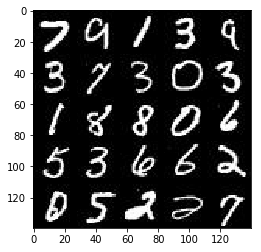

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

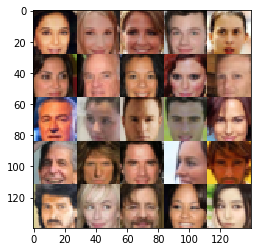

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'real_inputs') 
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name = 'z_inputs') # uniform noise
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
 
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Three conv layers followed by a fully connected layer with dropout
        
        conv1 = tf.layers.conv2d(images, 56, 5, 2, 'SAME')
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 112, 5, 2, 'SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 224, 5, 2, 'SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3)
        
        flat   = tf.reshape(conv3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        
        logits = tf.layers.dropout(logits, rate=0.5)
        
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        fully = tf.layers.dense(z, 7*7*112)
        fully = tf.reshape(fully, (-1, 7, 7, 112))
        fully = tf.layers.batch_normalization(fully, training=is_train)
        fully = tf.maximum(alpha*fully, fully)
        
        conv1 = tf.layers.conv2d_transpose(fully, 56, 5, 2, 'SAME')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, out_channel_dim, 5, 2, 'SAME')
        output = tf.tanh(conv2)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    generator_model = generator(input_z, out_channel_dim)
    
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, True)
    
    discriminator_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, \
        labels=tf.ones_like(discriminator_logits_real)*np.random.uniform(0.7, 1.2)))
    discriminator_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, \
        labels=tf.zeros_like(discriminator_logits_fake)*np.random.uniform(0.0, 0.3)))
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    general_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))
    
    return discriminator_loss, general_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    print_every = 10
    show_every = 100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                steps += 1
                
                batch_images = batch_images*2 # normalise input
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) # input noise

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate}) # optimizer
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate}) # optimizer
            
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7396... Generator Loss: 0.6383
Epoch 1/2... Discriminator Loss: 0.2379... Generator Loss: 1.7036
Epoch 1/2... Discriminator Loss: 1.1105... Generator Loss: 0.5098
Epoch 1/2... Discriminator Loss: 0.7554... Generator Loss: 0.9173
Epoch 1/2... Discriminator Loss: 0.0195... Generator Loss: 3.5134
Epoch 1/2... Discriminator Loss: 1.5531... Generator Loss: 0.2272
Epoch 1/2... Discriminator Loss: 0.2463... Generator Loss: 1.8384
Epoch 1/2... Discriminator Loss: 1.7695... Generator Loss: 8.4469
Epoch 1/2... Discriminator Loss: 0.1959... Generator Loss: 2.0946
Epoch 1/2... Discriminator Loss: 0.3419... Generator Loss: 1.4616


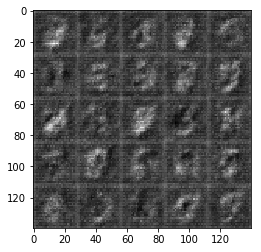

Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 5.3768
Epoch 1/2... Discriminator Loss: 0.6512... Generator Loss: 0.8054
Epoch 1/2... Discriminator Loss: 0.4422... Generator Loss: 1.1044
Epoch 1/2... Discriminator Loss: 2.6466... Generator Loss: 0.0887
Epoch 1/2... Discriminator Loss: 0.6511... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 0.2881
Epoch 1/2... Discriminator Loss: 0.2577... Generator Loss: 1.7546
Epoch 1/2... Discriminator Loss: 0.7671... Generator Loss: 3.8990
Epoch 1/2... Discriminator Loss: 0.5474... Generator Loss: 3.6064
Epoch 1/2... Discriminator Loss: 0.3802... Generator Loss: 1.6836


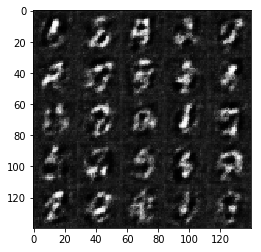

Epoch 1/2... Discriminator Loss: 0.4039... Generator Loss: 1.9895
Epoch 1/2... Discriminator Loss: 0.4581... Generator Loss: 2.4416
Epoch 1/2... Discriminator Loss: 0.3267... Generator Loss: 1.6305
Epoch 1/2... Discriminator Loss: 1.2086... Generator Loss: 0.4647
Epoch 1/2... Discriminator Loss: 0.3175... Generator Loss: 1.4319
Epoch 1/2... Discriminator Loss: 0.1919... Generator Loss: 2.1353
Epoch 1/2... Discriminator Loss: 2.0867... Generator Loss: 6.0288
Epoch 1/2... Discriminator Loss: 0.3299... Generator Loss: 1.6027
Epoch 1/2... Discriminator Loss: 0.3614... Generator Loss: 1.4578
Epoch 1/2... Discriminator Loss: 1.1055... Generator Loss: 0.4449


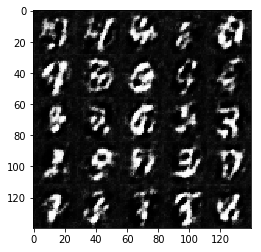

Epoch 1/2... Discriminator Loss: 0.4005... Generator Loss: 2.9998
Epoch 1/2... Discriminator Loss: 0.2506... Generator Loss: 2.7069
Epoch 1/2... Discriminator Loss: 0.2913... Generator Loss: 1.6672
Epoch 1/2... Discriminator Loss: 0.3731... Generator Loss: 1.2409
Epoch 1/2... Discriminator Loss: 0.4742... Generator Loss: 4.0898
Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 0.3019
Epoch 1/2... Discriminator Loss: 0.2560... Generator Loss: 1.8777
Epoch 1/2... Discriminator Loss: 0.2528... Generator Loss: 2.3448
Epoch 1/2... Discriminator Loss: 0.6245... Generator Loss: 3.9512
Epoch 1/2... Discriminator Loss: 0.2917... Generator Loss: 1.5902


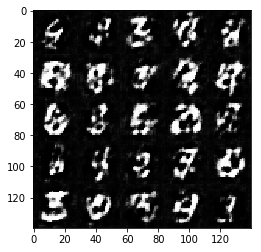

Epoch 1/2... Discriminator Loss: 0.2709... Generator Loss: 2.4942
Epoch 1/2... Discriminator Loss: 0.4716... Generator Loss: 1.0189
Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 5.5040
Epoch 1/2... Discriminator Loss: 0.2648... Generator Loss: 1.6211
Epoch 1/2... Discriminator Loss: 0.3872... Generator Loss: 1.3453
Epoch 1/2... Discriminator Loss: 0.7643... Generator Loss: 0.8415
Epoch 1/2... Discriminator Loss: 0.3548... Generator Loss: 1.4885
Epoch 1/2... Discriminator Loss: 0.4433... Generator Loss: 1.1840
Epoch 1/2... Discriminator Loss: 0.2778... Generator Loss: 3.1472
Epoch 1/2... Discriminator Loss: 0.3117... Generator Loss: 1.5850


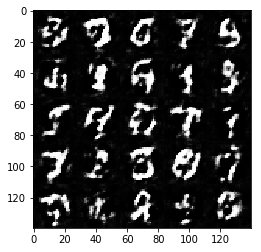

Epoch 1/2... Discriminator Loss: 0.2096... Generator Loss: 3.6665
Epoch 1/2... Discriminator Loss: 0.5127... Generator Loss: 3.4763
Epoch 1/2... Discriminator Loss: 0.5968... Generator Loss: 0.9877
Epoch 1/2... Discriminator Loss: 0.2395... Generator Loss: 1.6495
Epoch 1/2... Discriminator Loss: 0.2874... Generator Loss: 1.4892
Epoch 1/2... Discriminator Loss: 0.2501... Generator Loss: 2.4019
Epoch 1/2... Discriminator Loss: 0.5368... Generator Loss: 1.0547
Epoch 1/2... Discriminator Loss: 0.6477... Generator Loss: 0.9585
Epoch 1/2... Discriminator Loss: 0.3876... Generator Loss: 1.3730
Epoch 1/2... Discriminator Loss: 0.3437... Generator Loss: 1.3566


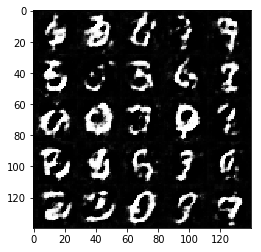

Epoch 1/2... Discriminator Loss: 0.4145... Generator Loss: 1.3990
Epoch 1/2... Discriminator Loss: 0.3351... Generator Loss: 1.4783
Epoch 1/2... Discriminator Loss: 0.2270... Generator Loss: 1.9284
Epoch 1/2... Discriminator Loss: 1.7803... Generator Loss: 7.8216
Epoch 1/2... Discriminator Loss: 0.7024... Generator Loss: 0.7698
Epoch 1/2... Discriminator Loss: 0.3611... Generator Loss: 1.4603
Epoch 1/2... Discriminator Loss: 0.3206... Generator Loss: 1.4548
Epoch 1/2... Discriminator Loss: 0.4558... Generator Loss: 1.2416
Epoch 1/2... Discriminator Loss: 0.3065... Generator Loss: 1.9553
Epoch 1/2... Discriminator Loss: 0.4013... Generator Loss: 1.3846


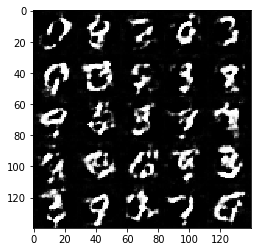

Epoch 1/2... Discriminator Loss: 0.3148... Generator Loss: 4.2739
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 0.7005
Epoch 1/2... Discriminator Loss: 0.2139... Generator Loss: 1.9472
Epoch 1/2... Discriminator Loss: 0.2723... Generator Loss: 1.6006
Epoch 1/2... Discriminator Loss: 0.3926... Generator Loss: 1.0939
Epoch 1/2... Discriminator Loss: 0.3852... Generator Loss: 1.3758
Epoch 1/2... Discriminator Loss: 0.4750... Generator Loss: 1.1828
Epoch 1/2... Discriminator Loss: 0.3698... Generator Loss: 1.7080
Epoch 1/2... Discriminator Loss: 0.4025... Generator Loss: 3.4319
Epoch 1/2... Discriminator Loss: 0.7290... Generator Loss: 0.7171


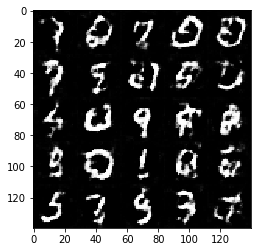

Epoch 1/2... Discriminator Loss: 0.6446... Generator Loss: 0.9017
Epoch 1/2... Discriminator Loss: 0.2301... Generator Loss: 1.7388
Epoch 1/2... Discriminator Loss: 0.3432... Generator Loss: 1.3625
Epoch 1/2... Discriminator Loss: 0.4886... Generator Loss: 1.3285
Epoch 1/2... Discriminator Loss: 0.5407... Generator Loss: 1.0780
Epoch 1/2... Discriminator Loss: 1.0120... Generator Loss: 0.6249
Epoch 1/2... Discriminator Loss: 0.1745... Generator Loss: 2.0614
Epoch 1/2... Discriminator Loss: 1.9458... Generator Loss: 7.2117
Epoch 1/2... Discriminator Loss: 0.2446... Generator Loss: 1.9848
Epoch 1/2... Discriminator Loss: 0.2980... Generator Loss: 2.0249


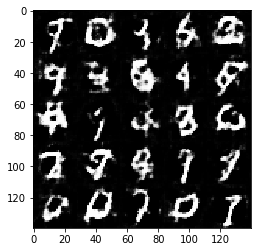

Epoch 1/2... Discriminator Loss: 0.1564... Generator Loss: 2.5036
Epoch 1/2... Discriminator Loss: 0.6529... Generator Loss: 0.8666
Epoch 1/2... Discriminator Loss: 0.2776... Generator Loss: 2.2653
Epoch 1/2... Discriminator Loss: 0.5178... Generator Loss: 1.1491
Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 0.9006
Epoch 1/2... Discriminator Loss: 0.7196... Generator Loss: 0.7892
Epoch 1/2... Discriminator Loss: 0.4426... Generator Loss: 1.3231
Epoch 1/2... Discriminator Loss: 0.5776... Generator Loss: 1.0473
Epoch 1/2... Discriminator Loss: 0.4701... Generator Loss: 1.1661
Epoch 1/2... Discriminator Loss: 0.7210... Generator Loss: 0.8071


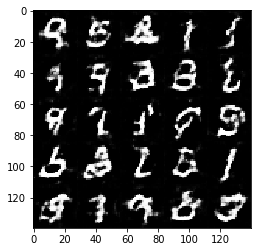

Epoch 1/2... Discriminator Loss: 0.2810... Generator Loss: 1.6315
Epoch 1/2... Discriminator Loss: 1.3215... Generator Loss: 0.4082
Epoch 1/2... Discriminator Loss: 0.3670... Generator Loss: 1.4792
Epoch 1/2... Discriminator Loss: 0.3134... Generator Loss: 1.4502
Epoch 1/2... Discriminator Loss: 0.4674... Generator Loss: 1.2439
Epoch 1/2... Discriminator Loss: 0.7404... Generator Loss: 0.7591
Epoch 1/2... Discriminator Loss: 1.2954... Generator Loss: 0.4016
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 0.9029
Epoch 1/2... Discriminator Loss: 0.5124... Generator Loss: 1.0051
Epoch 1/2... Discriminator Loss: 0.8303... Generator Loss: 0.6940


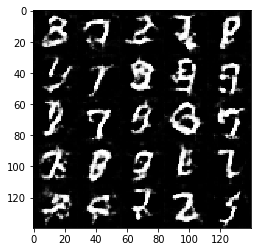

Epoch 1/2... Discriminator Loss: 0.5711... Generator Loss: 0.9897
Epoch 1/2... Discriminator Loss: 0.3223... Generator Loss: 1.8178
Epoch 1/2... Discriminator Loss: 0.8999... Generator Loss: 0.6603
Epoch 1/2... Discriminator Loss: 0.4812... Generator Loss: 3.4504
Epoch 1/2... Discriminator Loss: 0.4297... Generator Loss: 2.9414
Epoch 1/2... Discriminator Loss: 0.5725... Generator Loss: 0.9691
Epoch 1/2... Discriminator Loss: 0.5301... Generator Loss: 4.7186
Epoch 1/2... Discriminator Loss: 0.4278... Generator Loss: 1.5697
Epoch 1/2... Discriminator Loss: 0.5489... Generator Loss: 1.2646
Epoch 1/2... Discriminator Loss: 0.5776... Generator Loss: 0.9135


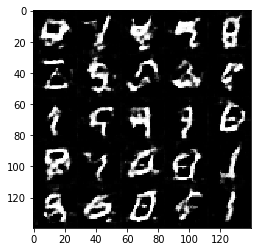

Epoch 1/2... Discriminator Loss: 0.4473... Generator Loss: 1.3145
Epoch 1/2... Discriminator Loss: 0.8876... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 0.4938... Generator Loss: 1.0411
Epoch 1/2... Discriminator Loss: 0.3067... Generator Loss: 1.5173
Epoch 1/2... Discriminator Loss: 0.4382... Generator Loss: 1.2141
Epoch 1/2... Discriminator Loss: 0.5384... Generator Loss: 1.0066
Epoch 1/2... Discriminator Loss: 0.7941... Generator Loss: 0.7239
Epoch 1/2... Discriminator Loss: 0.8296... Generator Loss: 0.7017
Epoch 1/2... Discriminator Loss: 0.4043... Generator Loss: 1.8339
Epoch 1/2... Discriminator Loss: 0.5620... Generator Loss: 1.0043


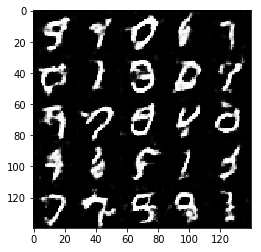

Epoch 1/2... Discriminator Loss: 1.7282... Generator Loss: 0.4305
Epoch 1/2... Discriminator Loss: 0.3442... Generator Loss: 1.9135
Epoch 1/2... Discriminator Loss: 0.7148... Generator Loss: 0.7942
Epoch 1/2... Discriminator Loss: 0.6918... Generator Loss: 0.9052
Epoch 1/2... Discriminator Loss: 0.6806... Generator Loss: 0.9104
Epoch 1/2... Discriminator Loss: 0.4787... Generator Loss: 1.1430
Epoch 1/2... Discriminator Loss: 0.7240... Generator Loss: 0.8003
Epoch 1/2... Discriminator Loss: 0.2209... Generator Loss: 1.8684
Epoch 1/2... Discriminator Loss: 0.5833... Generator Loss: 0.9110
Epoch 1/2... Discriminator Loss: 0.2487... Generator Loss: 3.1694


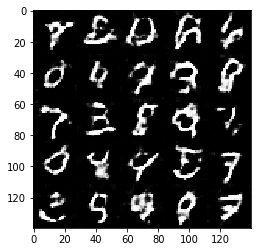

Epoch 1/2... Discriminator Loss: 0.3227... Generator Loss: 1.5484
Epoch 1/2... Discriminator Loss: 0.1978... Generator Loss: 1.8535
Epoch 1/2... Discriminator Loss: 0.4530... Generator Loss: 1.2097
Epoch 1/2... Discriminator Loss: 0.5910... Generator Loss: 0.9438
Epoch 1/2... Discriminator Loss: 0.7081... Generator Loss: 0.8374
Epoch 1/2... Discriminator Loss: 0.7030... Generator Loss: 4.1737
Epoch 1/2... Discriminator Loss: 0.3465... Generator Loss: 1.5138
Epoch 1/2... Discriminator Loss: 0.3770... Generator Loss: 1.2953
Epoch 1/2... Discriminator Loss: 0.5533... Generator Loss: 1.0504
Epoch 1/2... Discriminator Loss: 0.2042... Generator Loss: 1.8024


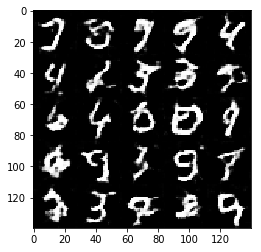

Epoch 1/2... Discriminator Loss: 0.3916... Generator Loss: 1.2082
Epoch 1/2... Discriminator Loss: 0.4828... Generator Loss: 1.2777
Epoch 1/2... Discriminator Loss: 0.7733... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 0.4337... Generator Loss: 1.2193
Epoch 1/2... Discriminator Loss: 0.3759... Generator Loss: 1.3446
Epoch 1/2... Discriminator Loss: 0.2319... Generator Loss: 1.5435
Epoch 1/2... Discriminator Loss: 0.2248... Generator Loss: 2.1397
Epoch 1/2... Discriminator Loss: 2.5445... Generator Loss: 6.4976
Epoch 1/2... Discriminator Loss: 0.4595... Generator Loss: 1.1644
Epoch 1/2... Discriminator Loss: 0.4763... Generator Loss: 1.0987


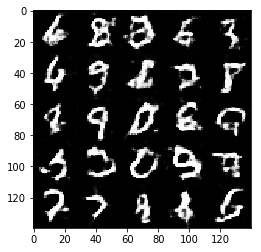

Epoch 1/2... Discriminator Loss: 0.3397... Generator Loss: 1.3951
Epoch 1/2... Discriminator Loss: 0.2862... Generator Loss: 1.5576
Epoch 1/2... Discriminator Loss: 0.6376... Generator Loss: 0.9678
Epoch 1/2... Discriminator Loss: 0.3152... Generator Loss: 1.4252
Epoch 1/2... Discriminator Loss: 0.4017... Generator Loss: 1.1593
Epoch 1/2... Discriminator Loss: 0.4087... Generator Loss: 1.1498
Epoch 1/2... Discriminator Loss: 0.6390... Generator Loss: 0.8701
Epoch 1/2... Discriminator Loss: 3.0940... Generator Loss: 7.6118
Epoch 1/2... Discriminator Loss: 0.3360... Generator Loss: 1.5722
Epoch 1/2... Discriminator Loss: 0.4546... Generator Loss: 1.2261


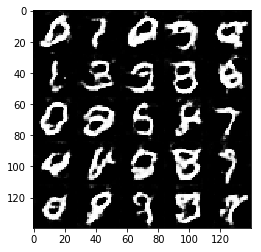

Epoch 1/2... Discriminator Loss: 0.5051... Generator Loss: 1.2905
Epoch 1/2... Discriminator Loss: 0.4459... Generator Loss: 1.2926
Epoch 1/2... Discriminator Loss: 0.3479... Generator Loss: 1.3349
Epoch 1/2... Discriminator Loss: 0.5536... Generator Loss: 0.9830
Epoch 1/2... Discriminator Loss: 0.4828... Generator Loss: 1.0947
Epoch 1/2... Discriminator Loss: 0.9518... Generator Loss: 0.5435
Epoch 1/2... Discriminator Loss: 0.3197... Generator Loss: 1.4251
Epoch 1/2... Discriminator Loss: 0.6580... Generator Loss: 0.9019
Epoch 1/2... Discriminator Loss: 0.6262... Generator Loss: 1.0144
Epoch 1/2... Discriminator Loss: 0.3678... Generator Loss: 1.4391


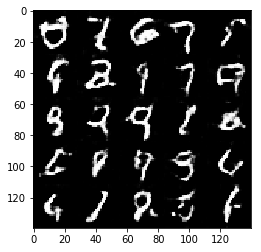

Epoch 1/2... Discriminator Loss: 0.4095... Generator Loss: 1.2284
Epoch 1/2... Discriminator Loss: 0.7837... Generator Loss: 0.7139
Epoch 1/2... Discriminator Loss: 0.6920... Generator Loss: 0.7850
Epoch 1/2... Discriminator Loss: 1.6847... Generator Loss: 0.2770
Epoch 1/2... Discriminator Loss: 0.2983... Generator Loss: 1.5504
Epoch 1/2... Discriminator Loss: 1.8568... Generator Loss: 0.2028
Epoch 1/2... Discriminator Loss: 2.0169... Generator Loss: 0.4122
Epoch 2/2... Discriminator Loss: 0.8977... Generator Loss: 0.6156
Epoch 2/2... Discriminator Loss: 0.1811... Generator Loss: 2.4418
Epoch 2/2... Discriminator Loss: 0.1972... Generator Loss: 1.8700


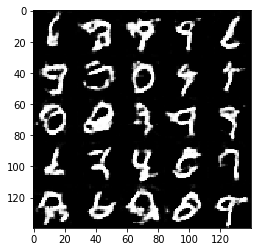

Epoch 2/2... Discriminator Loss: 0.4539... Generator Loss: 1.1220
Epoch 2/2... Discriminator Loss: 0.3849... Generator Loss: 1.2482
Epoch 2/2... Discriminator Loss: 0.2736... Generator Loss: 1.5514
Epoch 2/2... Discriminator Loss: 0.3446... Generator Loss: 1.3004
Epoch 2/2... Discriminator Loss: 0.2627... Generator Loss: 1.5818
Epoch 2/2... Discriminator Loss: 0.0942... Generator Loss: 2.1026
Epoch 2/2... Discriminator Loss: 0.5812... Generator Loss: 0.9672
Epoch 2/2... Discriminator Loss: 0.5925... Generator Loss: 0.9739
Epoch 2/2... Discriminator Loss: 0.6790... Generator Loss: 0.8587
Epoch 2/2... Discriminator Loss: 0.7635... Generator Loss: 0.7546


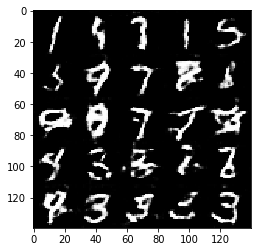

Epoch 2/2... Discriminator Loss: 0.2952... Generator Loss: 1.3851
Epoch 2/2... Discriminator Loss: 0.3309... Generator Loss: 1.4236
Epoch 2/2... Discriminator Loss: 0.0190... Generator Loss: 3.7309
Epoch 2/2... Discriminator Loss: 0.4380... Generator Loss: 1.0410
Epoch 2/2... Discriminator Loss: 1.4538... Generator Loss: 0.3345
Epoch 2/2... Discriminator Loss: 1.9323... Generator Loss: 0.2276
Epoch 2/2... Discriminator Loss: 0.2899... Generator Loss: 2.0071
Epoch 2/2... Discriminator Loss: 2.0885... Generator Loss: 0.1401
Epoch 2/2... Discriminator Loss: 0.6740... Generator Loss: 0.9185
Epoch 2/2... Discriminator Loss: 0.4054... Generator Loss: 1.2857


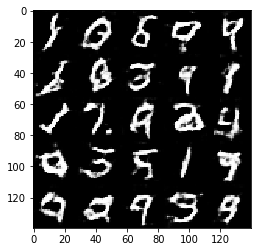

Epoch 2/2... Discriminator Loss: 0.3454... Generator Loss: 1.3890
Epoch 2/2... Discriminator Loss: 0.5039... Generator Loss: 1.0561
Epoch 2/2... Discriminator Loss: 0.3885... Generator Loss: 1.2976
Epoch 2/2... Discriminator Loss: 0.2928... Generator Loss: 1.4445
Epoch 2/2... Discriminator Loss: 0.4873... Generator Loss: 1.2845
Epoch 2/2... Discriminator Loss: 0.3992... Generator Loss: 1.1979
Epoch 2/2... Discriminator Loss: 0.4918... Generator Loss: 1.0832
Epoch 2/2... Discriminator Loss: 0.6454... Generator Loss: 1.0523
Epoch 2/2... Discriminator Loss: 0.0497... Generator Loss: 2.6128
Epoch 2/2... Discriminator Loss: 0.4103... Generator Loss: 1.1046


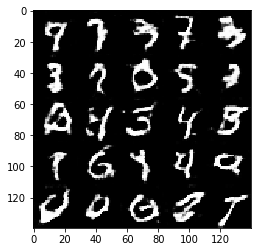

Epoch 2/2... Discriminator Loss: 0.4050... Generator Loss: 1.2805
Epoch 2/2... Discriminator Loss: 0.5290... Generator Loss: 1.2603
Epoch 2/2... Discriminator Loss: 0.5624... Generator Loss: 0.9704
Epoch 2/2... Discriminator Loss: 0.3412... Generator Loss: 1.3754
Epoch 2/2... Discriminator Loss: 0.6149... Generator Loss: 0.9246
Epoch 2/2... Discriminator Loss: 0.4081... Generator Loss: 1.2092
Epoch 2/2... Discriminator Loss: 0.5022... Generator Loss: 0.9910
Epoch 2/2... Discriminator Loss: 0.1408... Generator Loss: 2.0520
Epoch 2/2... Discriminator Loss: 0.4880... Generator Loss: 1.0619
Epoch 2/2... Discriminator Loss: 0.6256... Generator Loss: 0.9787


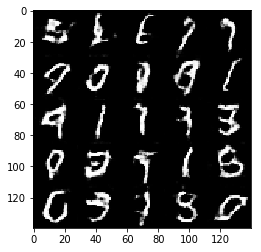

Epoch 2/2... Discriminator Loss: 1.6594... Generator Loss: 0.3230
Epoch 2/2... Discriminator Loss: 0.5592... Generator Loss: 1.0300
Epoch 2/2... Discriminator Loss: 0.5223... Generator Loss: 1.0212
Epoch 2/2... Discriminator Loss: 0.2674... Generator Loss: 1.3923
Epoch 2/2... Discriminator Loss: 2.2754... Generator Loss: 0.4152
Epoch 2/2... Discriminator Loss: 0.4719... Generator Loss: 1.0217
Epoch 2/2... Discriminator Loss: 0.5150... Generator Loss: 1.0536
Epoch 2/2... Discriminator Loss: 0.7031... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 0.4487... Generator Loss: 1.1184
Epoch 2/2... Discriminator Loss: 0.8710... Generator Loss: 0.7784


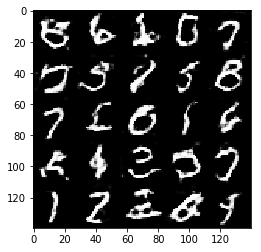

Epoch 2/2... Discriminator Loss: 0.7893... Generator Loss: 0.7562
Epoch 2/2... Discriminator Loss: 0.1467... Generator Loss: 1.7919
Epoch 2/2... Discriminator Loss: 0.4335... Generator Loss: 1.2563
Epoch 2/2... Discriminator Loss: 0.3247... Generator Loss: 1.3899
Epoch 2/2... Discriminator Loss: 0.3406... Generator Loss: 1.3132
Epoch 2/2... Discriminator Loss: 1.0203... Generator Loss: 0.6371
Epoch 2/2... Discriminator Loss: 0.2367... Generator Loss: 1.5550
Epoch 2/2... Discriminator Loss: 0.9538... Generator Loss: 0.6688
Epoch 2/2... Discriminator Loss: 1.9467... Generator Loss: 0.3284
Epoch 2/2... Discriminator Loss: 0.3082... Generator Loss: 2.3541


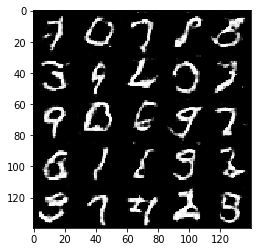

Epoch 2/2... Discriminator Loss: 1.8594... Generator Loss: 0.2319
Epoch 2/2... Discriminator Loss: 0.2167... Generator Loss: 1.5491
Epoch 2/2... Discriminator Loss: 0.3749... Generator Loss: 1.2765
Epoch 2/2... Discriminator Loss: 0.1821... Generator Loss: 1.8805
Epoch 2/2... Discriminator Loss: 0.4871... Generator Loss: 1.2416
Epoch 2/2... Discriminator Loss: 0.7349... Generator Loss: 0.8412
Epoch 2/2... Discriminator Loss: 0.4429... Generator Loss: 1.2532
Epoch 2/2... Discriminator Loss: 0.3195... Generator Loss: 1.6047
Epoch 2/2... Discriminator Loss: 0.9138... Generator Loss: 0.5918
Epoch 2/2... Discriminator Loss: 0.4570... Generator Loss: 1.1736


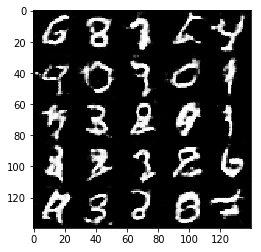

Epoch 2/2... Discriminator Loss: 0.2626... Generator Loss: 1.6130
Epoch 2/2... Discriminator Loss: 0.5165... Generator Loss: 1.2088
Epoch 2/2... Discriminator Loss: 0.5606... Generator Loss: 1.0605
Epoch 2/2... Discriminator Loss: 0.2882... Generator Loss: 1.4571
Epoch 2/2... Discriminator Loss: 0.3522... Generator Loss: 1.2919
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 0.5777
Epoch 2/2... Discriminator Loss: 0.6087... Generator Loss: 1.1000
Epoch 2/2... Discriminator Loss: 0.5059... Generator Loss: 1.1185
Epoch 2/2... Discriminator Loss: 0.5074... Generator Loss: 1.1461
Epoch 2/2... Discriminator Loss: 0.3042... Generator Loss: 1.4076


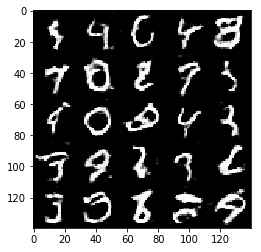

Epoch 2/2... Discriminator Loss: 0.4286... Generator Loss: 1.1038
Epoch 2/2... Discriminator Loss: 0.7875... Generator Loss: 0.7580
Epoch 2/2... Discriminator Loss: 1.3013... Generator Loss: 0.3882
Epoch 2/2... Discriminator Loss: 0.4143... Generator Loss: 1.2485
Epoch 2/2... Discriminator Loss: 0.5455... Generator Loss: 0.9198
Epoch 2/2... Discriminator Loss: 0.0788... Generator Loss: 3.9077
Epoch 2/2... Discriminator Loss: 0.2753... Generator Loss: 2.6692
Epoch 2/2... Discriminator Loss: 0.5259... Generator Loss: 3.9023
Epoch 2/2... Discriminator Loss: 0.2970... Generator Loss: 1.5199
Epoch 2/2... Discriminator Loss: 0.9054... Generator Loss: 0.6910


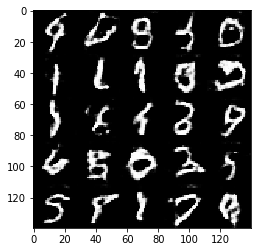

Epoch 2/2... Discriminator Loss: 0.4195... Generator Loss: 1.1992
Epoch 2/2... Discriminator Loss: 0.1919... Generator Loss: 1.4230
Epoch 2/2... Discriminator Loss: 4.0868... Generator Loss: 9.5329
Epoch 2/2... Discriminator Loss: 0.4320... Generator Loss: 2.7493
Epoch 2/2... Discriminator Loss: 0.1538... Generator Loss: 1.9774
Epoch 2/2... Discriminator Loss: 0.6519... Generator Loss: 0.9121
Epoch 2/2... Discriminator Loss: 0.4086... Generator Loss: 1.1811
Epoch 2/2... Discriminator Loss: 0.4648... Generator Loss: 1.1411
Epoch 2/2... Discriminator Loss: 0.3890... Generator Loss: 1.4103
Epoch 2/2... Discriminator Loss: 0.6792... Generator Loss: 0.7291


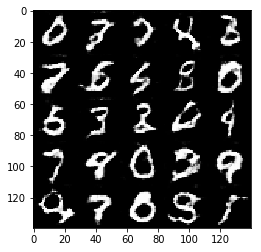

Epoch 2/2... Discriminator Loss: 0.7413... Generator Loss: 0.7939
Epoch 2/2... Discriminator Loss: 0.3804... Generator Loss: 1.3152
Epoch 2/2... Discriminator Loss: 0.5603... Generator Loss: 1.0396
Epoch 2/2... Discriminator Loss: 0.4628... Generator Loss: 1.0396
Epoch 2/2... Discriminator Loss: 0.6582... Generator Loss: 0.8489
Epoch 2/2... Discriminator Loss: 0.1324... Generator Loss: 2.2426
Epoch 2/2... Discriminator Loss: 0.6889... Generator Loss: 0.7825
Epoch 2/2... Discriminator Loss: 0.5916... Generator Loss: 1.0066
Epoch 2/2... Discriminator Loss: 0.5827... Generator Loss: 0.8030
Epoch 2/2... Discriminator Loss: 0.4841... Generator Loss: 1.0525


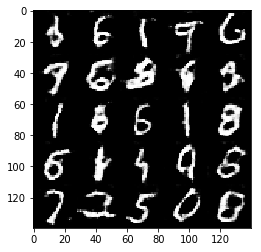

Epoch 2/2... Discriminator Loss: 0.4292... Generator Loss: 1.1362
Epoch 2/2... Discriminator Loss: 0.6156... Generator Loss: 0.9027
Epoch 2/2... Discriminator Loss: 0.7295... Generator Loss: 0.8420
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 0.9479
Epoch 2/2... Discriminator Loss: 0.9981... Generator Loss: 0.6143
Epoch 2/2... Discriminator Loss: 0.8487... Generator Loss: 0.7825
Epoch 2/2... Discriminator Loss: 1.6100... Generator Loss: 0.3796
Epoch 2/2... Discriminator Loss: 1.3442... Generator Loss: 0.3647
Epoch 2/2... Discriminator Loss: 0.9534... Generator Loss: 0.7032
Epoch 2/2... Discriminator Loss: 0.4828... Generator Loss: 1.2543


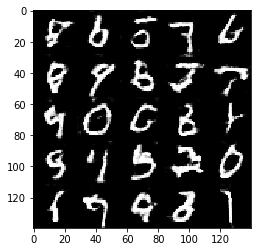

Epoch 2/2... Discriminator Loss: 1.0856... Generator Loss: 0.5859
Epoch 2/2... Discriminator Loss: 0.6007... Generator Loss: 0.9919
Epoch 2/2... Discriminator Loss: 0.5774... Generator Loss: 0.9887
Epoch 2/2... Discriminator Loss: 3.5391... Generator Loss: 0.1175
Epoch 2/2... Discriminator Loss: 2.7147... Generator Loss: 0.1796
Epoch 2/2... Discriminator Loss: 0.3358... Generator Loss: 2.6053
Epoch 2/2... Discriminator Loss: 0.3351... Generator Loss: 1.6583
Epoch 2/2... Discriminator Loss: 1.8307... Generator Loss: 0.3258
Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 0.9716
Epoch 2/2... Discriminator Loss: 0.3916... Generator Loss: 1.3856


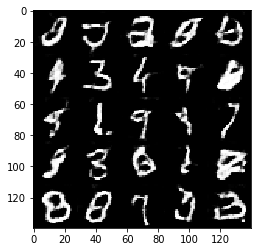

Epoch 2/2... Discriminator Loss: 0.6433... Generator Loss: 1.0062
Epoch 2/2... Discriminator Loss: 0.6502... Generator Loss: 0.9942
Epoch 2/2... Discriminator Loss: 0.5417... Generator Loss: 1.0319
Epoch 2/2... Discriminator Loss: 0.6657... Generator Loss: 0.8616
Epoch 2/2... Discriminator Loss: 0.6529... Generator Loss: 0.9791
Epoch 2/2... Discriminator Loss: 0.4645... Generator Loss: 1.0779
Epoch 2/2... Discriminator Loss: 0.1656... Generator Loss: 3.4038
Epoch 2/2... Discriminator Loss: 0.4227... Generator Loss: 1.0947
Epoch 2/2... Discriminator Loss: 0.5118... Generator Loss: 0.9431
Epoch 2/2... Discriminator Loss: 0.3677... Generator Loss: 1.2778


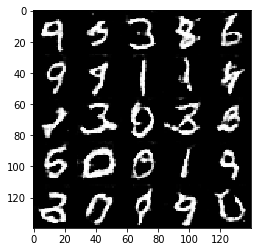

Epoch 2/2... Discriminator Loss: 0.4645... Generator Loss: 1.1463
Epoch 2/2... Discriminator Loss: 0.4541... Generator Loss: 1.0972
Epoch 2/2... Discriminator Loss: 0.4654... Generator Loss: 1.2193
Epoch 2/2... Discriminator Loss: 0.1768... Generator Loss: 1.6433
Epoch 2/2... Discriminator Loss: 0.5360... Generator Loss: 1.3089
Epoch 2/2... Discriminator Loss: 0.5490... Generator Loss: 0.9904
Epoch 2/2... Discriminator Loss: 0.4031... Generator Loss: 1.6665
Epoch 2/2... Discriminator Loss: 0.4210... Generator Loss: 1.3308
Epoch 2/2... Discriminator Loss: 0.2696... Generator Loss: 1.3006
Epoch 2/2... Discriminator Loss: 0.3441... Generator Loss: 1.0914


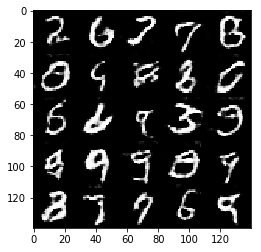

Epoch 2/2... Discriminator Loss: 1.1888... Generator Loss: 0.4968
Epoch 2/2... Discriminator Loss: 1.4175... Generator Loss: 0.7557
Epoch 2/2... Discriminator Loss: 2.0130... Generator Loss: 0.2065
Epoch 2/2... Discriminator Loss: 0.3701... Generator Loss: 1.3119
Epoch 2/2... Discriminator Loss: 0.5649... Generator Loss: 1.0433
Epoch 2/2... Discriminator Loss: 0.5708... Generator Loss: 0.9956
Epoch 2/2... Discriminator Loss: 0.5451... Generator Loss: 1.1091
Epoch 2/2... Discriminator Loss: 0.1330... Generator Loss: 1.6626
Epoch 2/2... Discriminator Loss: 0.3214... Generator Loss: 1.5669
Epoch 2/2... Discriminator Loss: 0.5064... Generator Loss: 1.2242


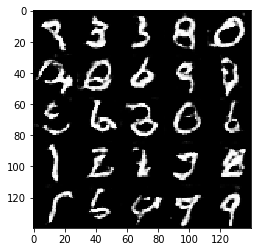

Epoch 2/2... Discriminator Loss: 0.9561... Generator Loss: 0.6537
Epoch 2/2... Discriminator Loss: 0.4607... Generator Loss: 1.2860
Epoch 2/2... Discriminator Loss: 0.5524... Generator Loss: 0.9512
Epoch 2/2... Discriminator Loss: 0.4653... Generator Loss: 1.0512
Epoch 2/2... Discriminator Loss: 0.5244... Generator Loss: 1.0597
Epoch 2/2... Discriminator Loss: 0.3592... Generator Loss: 1.3239
Epoch 2/2... Discriminator Loss: 0.7118... Generator Loss: 0.8533
Epoch 2/2... Discriminator Loss: 0.4952... Generator Loss: 1.0857
Epoch 2/2... Discriminator Loss: 0.7459... Generator Loss: 0.7302
Epoch 2/2... Discriminator Loss: 0.3683... Generator Loss: 1.2550


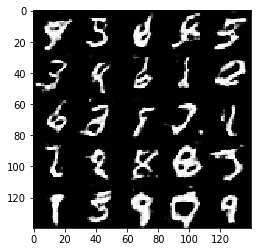

Epoch 2/2... Discriminator Loss: 0.6668... Generator Loss: 0.8946
Epoch 2/2... Discriminator Loss: 0.2696... Generator Loss: 1.4403
Epoch 2/2... Discriminator Loss: 0.3406... Generator Loss: 6.0157
Epoch 2/2... Discriminator Loss: 1.0854... Generator Loss: 0.5443
Epoch 2/2... Discriminator Loss: 0.4529... Generator Loss: 1.2193
Epoch 2/2... Discriminator Loss: 0.1583... Generator Loss: 2.0142
Epoch 2/2... Discriminator Loss: 0.2684... Generator Loss: 1.7062
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 0.9410
Epoch 2/2... Discriminator Loss: 0.5168... Generator Loss: 1.1288
Epoch 2/2... Discriminator Loss: 0.4029... Generator Loss: 1.1687


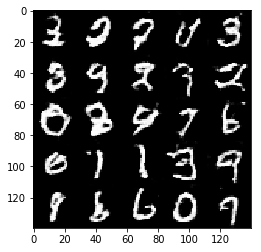

Epoch 2/2... Discriminator Loss: 0.4531... Generator Loss: 1.0566
Epoch 2/2... Discriminator Loss: 0.3590... Generator Loss: 1.3819
Epoch 2/2... Discriminator Loss: 0.3953... Generator Loss: 1.3549
Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 0.6284
Epoch 2/2... Discriminator Loss: 0.0644... Generator Loss: 2.1393


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: -1.4904... Generator Loss: 0.5224
Epoch 1/1... Discriminator Loss: -2.5603... Generator Loss: 3.3233
Epoch 1/1... Discriminator Loss: -0.9456... Generator Loss: 0.0857
Epoch 1/1... Discriminator Loss: -3.0905... Generator Loss: 1.7437
Epoch 1/1... Discriminator Loss: -0.3469... Generator Loss: 19.2985
Epoch 1/1... Discriminator Loss: -4.5569... Generator Loss: 5.9858
Epoch 1/1... Discriminator Loss: 1.9983... Generator Loss: 0.0174
Epoch 1/1... Discriminator Loss: -1.2934... Generator Loss: 1.1343
Epoch 1/1... Discriminator Loss: 0.1283... Generator Loss: 0.2537
Epoch 1/1... Discriminator Loss: -2.4904... Generator Loss: 3.0878


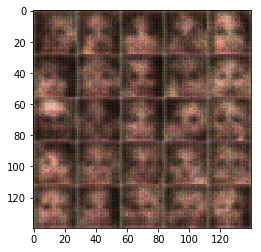

Epoch 1/1... Discriminator Loss: 6.2346... Generator Loss: 20.8037
Epoch 1/1... Discriminator Loss: -1.7195... Generator Loss: 1.4430
Epoch 1/1... Discriminator Loss: -0.4362... Generator Loss: 8.4467
Epoch 1/1... Discriminator Loss: -1.5093... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: -0.2635... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: -0.9234... Generator Loss: 1.7590
Epoch 1/1... Discriminator Loss: -1.7121... Generator Loss: 3.8331
Epoch 1/1... Discriminator Loss: 0.2252... Generator Loss: 0.4550
Epoch 1/1... Discriminator Loss: -1.4907... Generator Loss: 4.5946
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.0308


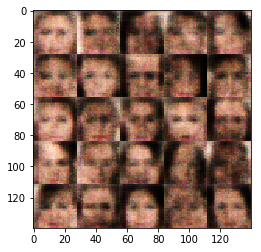

Epoch 1/1... Discriminator Loss: -1.6126... Generator Loss: 1.6858
Epoch 1/1... Discriminator Loss: -0.0195... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: -0.1569... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: -0.4697... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: -0.5871... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 0.2733
Epoch 1/1... Discriminator Loss: -1.1505... Generator Loss: 1.3105
Epoch 1/1... Discriminator Loss: 0.6529... Generator Loss: 0.4467
Epoch 1/1... Discriminator Loss: 4.4866... Generator Loss: 8.8916


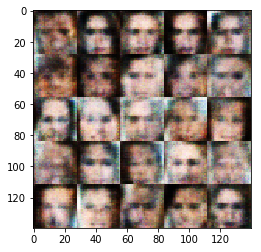

Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 0.1852
Epoch 1/1... Discriminator Loss: -1.2153... Generator Loss: 3.3018
Epoch 1/1... Discriminator Loss: 2.3650... Generator Loss: 0.0383
Epoch 1/1... Discriminator Loss: -0.4318... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: -0.5805... Generator Loss: 1.7176
Epoch 1/1... Discriminator Loss: -0.5581... Generator Loss: 2.8963
Epoch 1/1... Discriminator Loss: 0.1860... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.2423
Epoch 1/1... Discriminator Loss: 0.6593... Generator Loss: 0.4262
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 4.8684


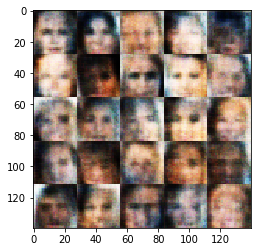

Epoch 1/1... Discriminator Loss: 0.5581... Generator Loss: 0.2591
Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 0.2537
Epoch 1/1... Discriminator Loss: -0.0144... Generator Loss: 3.5847
Epoch 1/1... Discriminator Loss: -0.4667... Generator Loss: 1.2202
Epoch 1/1... Discriminator Loss: -0.3232... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: -0.1236... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: -0.2494... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: -1.0732... Generator Loss: 2.2119
Epoch 1/1... Discriminator Loss: -0.1851... Generator Loss: 4.7157
Epoch 1/1... Discriminator Loss: -0.7326... Generator Loss: 3.4970


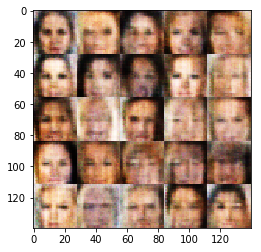

Epoch 1/1... Discriminator Loss: -0.9672... Generator Loss: 1.9853
Epoch 1/1... Discriminator Loss: 0.1261... Generator Loss: 0.3571
Epoch 1/1... Discriminator Loss: -1.3898... Generator Loss: 2.1725
Epoch 1/1... Discriminator Loss: 2.3720... Generator Loss: 0.0289
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.1916
Epoch 1/1... Discriminator Loss: 0.3030... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 0.4493... Generator Loss: 0.3576
Epoch 1/1... Discriminator Loss: -0.5429... Generator Loss: 1.2364
Epoch 1/1... Discriminator Loss: 0.2424... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.9731... Generator Loss: 0.1198


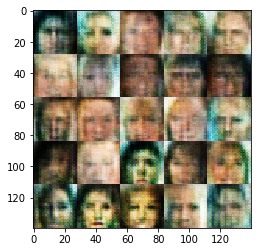

Epoch 1/1... Discriminator Loss: -0.6532... Generator Loss: 3.5383
Epoch 1/1... Discriminator Loss: -0.3180... Generator Loss: 2.1864
Epoch 1/1... Discriminator Loss: -0.4685... Generator Loss: 1.0712
Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 0.1997
Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 0.3349
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 7.8292
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 7.1333
Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 5.7850
Epoch 1/1... Discriminator Loss: -0.1766... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: -0.5979... Generator Loss: 1.3780


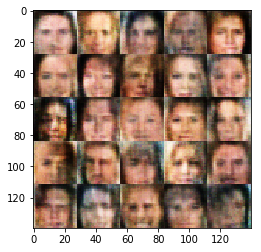

Epoch 1/1... Discriminator Loss: -0.4832... Generator Loss: 1.4420
Epoch 1/1... Discriminator Loss: 0.3586... Generator Loss: 0.4187
Epoch 1/1... Discriminator Loss: 0.1744... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 0.3684
Epoch 1/1... Discriminator Loss: -0.4449... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: -0.2451... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 2.1498... Generator Loss: 6.9104
Epoch 1/1... Discriminator Loss: -0.0564... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 0.2079... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: 0.2394... Generator Loss: 0.4593


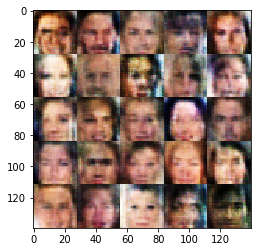

Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 0.2688
Epoch 1/1... Discriminator Loss: -0.0169... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 5.1974
Epoch 1/1... Discriminator Loss: 1.8697... Generator Loss: 0.1364
Epoch 1/1... Discriminator Loss: 2.0264... Generator Loss: 0.0559
Epoch 1/1... Discriminator Loss: 0.1011... Generator Loss: 1.5796
Epoch 1/1... Discriminator Loss: -0.2081... Generator Loss: 3.0043
Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 0.4063
Epoch 1/1... Discriminator Loss: 0.3086... Generator Loss: 0.4564
Epoch 1/1... Discriminator Loss: 1.5784... Generator Loss: 5.9715


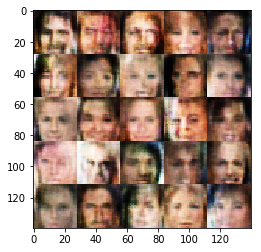

Epoch 1/1... Discriminator Loss: 0.7342... Generator Loss: 0.2671
Epoch 1/1... Discriminator Loss: -0.1140... Generator Loss: 2.6296
Epoch 1/1... Discriminator Loss: -0.0641... Generator Loss: 1.5984
Epoch 1/1... Discriminator Loss: -0.2642... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: -0.2404... Generator Loss: 2.2001
Epoch 1/1... Discriminator Loss: -0.1604... Generator Loss: 2.5362
Epoch 1/1... Discriminator Loss: 0.4067... Generator Loss: 0.3176
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 5.1405
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 4.4265
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 0.3133


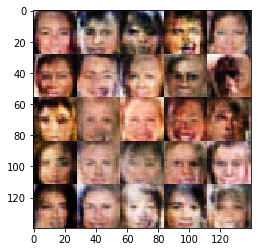

Epoch 1/1... Discriminator Loss: -0.0111... Generator Loss: 0.4364
Epoch 1/1... Discriminator Loss: -0.2849... Generator Loss: 1.2207
Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 0.2640
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.1585
Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 0.3747
Epoch 1/1... Discriminator Loss: 0.1928... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: -0.1598... Generator Loss: 1.4130
Epoch 1/1... Discriminator Loss: 0.3192... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: -0.0518... Generator Loss: 3.8236
Epoch 1/1... Discriminator Loss: 0.3074... Generator Loss: 0.3986


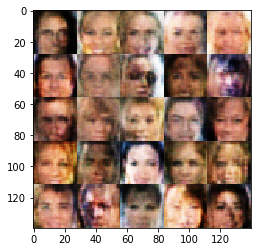

Epoch 1/1... Discriminator Loss: 0.2709... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 0.1083... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 0.3311... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 0.3309... Generator Loss: 0.4123
Epoch 1/1... Discriminator Loss: -0.3916... Generator Loss: 1.4402
Epoch 1/1... Discriminator Loss: -0.2508... Generator Loss: 1.2216
Epoch 1/1... Discriminator Loss: 0.0105... Generator Loss: 1.1478
Epoch 1/1... Discriminator Loss: 0.1515... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 0.2519... Generator Loss: 3.1035
Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 2.8583


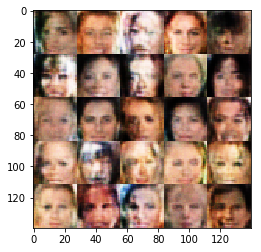

Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.2597
Epoch 1/1... Discriminator Loss: -0.0169... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 0.1756... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: -0.1259... Generator Loss: 1.2539
Epoch 1/1... Discriminator Loss: -0.2333... Generator Loss: 1.4215
Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 2.8765
Epoch 1/1... Discriminator Loss: -0.0358... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.1152
Epoch 1/1... Discriminator Loss: 0.4444... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 4.1126


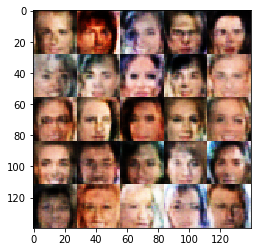

Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 4.5938
Epoch 1/1... Discriminator Loss: 0.2587... Generator Loss: 0.4983
Epoch 1/1... Discriminator Loss: 0.3007... Generator Loss: 0.4191
Epoch 1/1... Discriminator Loss: 0.0589... Generator Loss: 1.9857
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 0.2426
Epoch 1/1... Discriminator Loss: -0.0106... Generator Loss: 1.4687
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 2.0210
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.0921
Epoch 1/1... Discriminator Loss: -0.1370... Generator Loss: 1.6743
Epoch 1/1... Discriminator Loss: 0.1075... Generator Loss: 2.0679


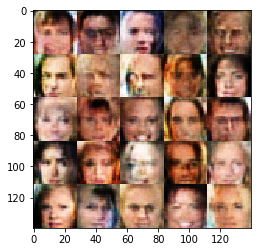

Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 0.2166
Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 0.3133
Epoch 1/1... Discriminator Loss: -0.3819... Generator Loss: 2.7209
Epoch 1/1... Discriminator Loss: 0.1068... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 0.2472... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.1605
Epoch 1/1... Discriminator Loss: -0.4185... Generator Loss: 2.9663
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 1.9712
Epoch 1/1... Discriminator Loss: 0.2441... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: -0.0914... Generator Loss: 1.3019


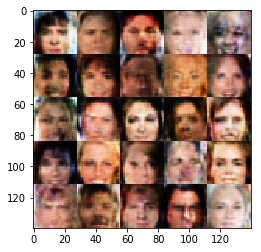

Epoch 1/1... Discriminator Loss: 3.5068... Generator Loss: 6.0414
Epoch 1/1... Discriminator Loss: 0.4428... Generator Loss: 2.7537
Epoch 1/1... Discriminator Loss: -0.1313... Generator Loss: 1.3161
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 0.1531
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 0.2315
Epoch 1/1... Discriminator Loss: -0.2129... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 0.0981... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 0.2607
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.2398
Epoch 1/1... Discriminator Loss: 2.9347... Generator Loss: 0.0333


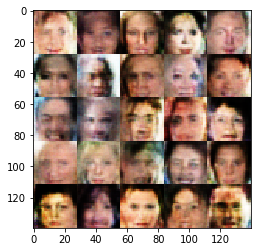

Epoch 1/1... Discriminator Loss: 0.2972... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 0.5468... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 0.7801... Generator Loss: 0.2919
Epoch 1/1... Discriminator Loss: 0.2308... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 2.6019... Generator Loss: 0.0579
Epoch 1/1... Discriminator Loss: -0.4096... Generator Loss: 3.0153
Epoch 1/1... Discriminator Loss: -0.1058... Generator Loss: 1.6461
Epoch 1/1... Discriminator Loss: -0.0849... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 0.5625... Generator Loss: 0.3842
Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 0.3974


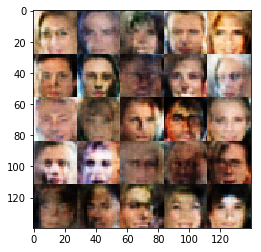

Epoch 1/1... Discriminator Loss: 0.5693... Generator Loss: 0.3703
Epoch 1/1... Discriminator Loss: -0.3867... Generator Loss: 1.6404
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.1786
Epoch 1/1... Discriminator Loss: 0.4564... Generator Loss: 0.4205
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 0.2348
Epoch 1/1... Discriminator Loss: -0.1192... Generator Loss: 2.8821
Epoch 1/1... Discriminator Loss: -0.4490... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 0.1833... Generator Loss: 1.2134
Epoch 1/1... Discriminator Loss: -0.2306... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: -0.3593... Generator Loss: 1.0198


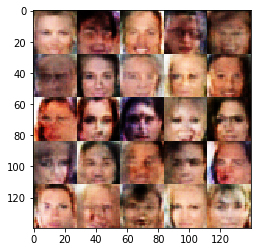

Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 0.3141
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.2160
Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 0.2690
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.1528
Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 0.2089... Generator Loss: 0.4308
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 0.3167
Epoch 1/1... Discriminator Loss: 0.3379... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.1002


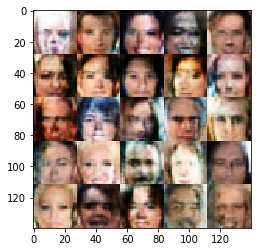

Epoch 1/1... Discriminator Loss: 0.2976... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: -0.1743... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 0.2670
Epoch 1/1... Discriminator Loss: -0.2491... Generator Loss: 1.8910
Epoch 1/1... Discriminator Loss: -0.8725... Generator Loss: 4.6738
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 0.2845
Epoch 1/1... Discriminator Loss: 2.3353... Generator Loss: 0.0813
Epoch 1/1... Discriminator Loss: 0.2588... Generator Loss: 0.5720


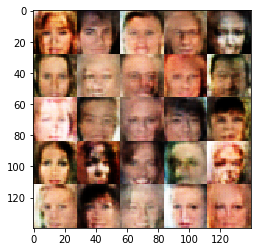

Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 4.9475
Epoch 1/1... Discriminator Loss: 0.4056... Generator Loss: 0.3456
Epoch 1/1... Discriminator Loss: 0.7994... Generator Loss: 0.4253
Epoch 1/1... Discriminator Loss: -0.0391... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 0.2035
Epoch 1/1... Discriminator Loss: 0.2875... Generator Loss: 2.7920
Epoch 1/1... Discriminator Loss: -0.2522... Generator Loss: 2.2042
Epoch 1/1... Discriminator Loss: -0.4887... Generator Loss: 2.4293
Epoch 1/1... Discriminator Loss: 0.4844... Generator Loss: 0.4190
Epoch 1/1... Discriminator Loss: -0.3632... Generator Loss: 1.4172


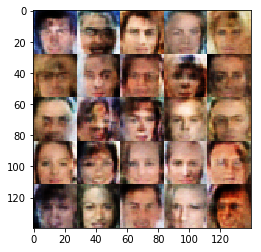

Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 0.2312
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 0.3132
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 6.0235
Epoch 1/1... Discriminator Loss: 0.0859... Generator Loss: 0.4207
Epoch 1/1... Discriminator Loss: -0.7889... Generator Loss: 1.5846
Epoch 1/1... Discriminator Loss: -0.2698... Generator Loss: 1.5688
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.1902
Epoch 1/1... Discriminator Loss: -0.0528... Generator Loss: 1.8331
Epoch 1/1... Discriminator Loss: 0.6766... Generator Loss: 0.4552
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 0.1920


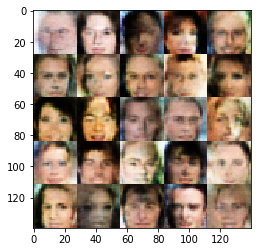

Epoch 1/1... Discriminator Loss: 1.5898... Generator Loss: 0.1147
Epoch 1/1... Discriminator Loss: 0.5378... Generator Loss: 0.3549
Epoch 1/1... Discriminator Loss: 0.0166... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: -0.7878... Generator Loss: 1.3125
Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 0.3056
Epoch 1/1... Discriminator Loss: 3.0075... Generator Loss: 0.0437
Epoch 1/1... Discriminator Loss: -0.0699... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: -0.2762... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: -0.2785... Generator Loss: 3.8821
Epoch 1/1... Discriminator Loss: 0.2426... Generator Loss: 2.5151


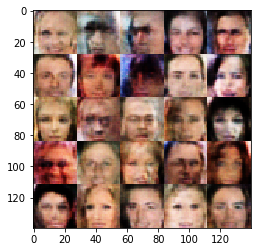

Epoch 1/1... Discriminator Loss: -0.0676... Generator Loss: 0.5437
Epoch 1/1... Discriminator Loss: 0.5586... Generator Loss: 0.4925
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 0.2039
Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 0.5359... Generator Loss: 2.4282
Epoch 1/1... Discriminator Loss: 0.4247... Generator Loss: 1.9934
Epoch 1/1... Discriminator Loss: -0.0108... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 0.3922... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: -0.4952... Generator Loss: 3.0315
Epoch 1/1... Discriminator Loss: 0.3637... Generator Loss: 2.9145


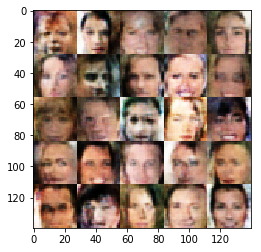

Epoch 1/1... Discriminator Loss: -0.1501... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: -0.0361... Generator Loss: 2.7552
Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 2.6279
Epoch 1/1... Discriminator Loss: 1.8742... Generator Loss: 0.0879
Epoch 1/1... Discriminator Loss: 0.0318... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: -0.5992... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 0.1818
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.1935
Epoch 1/1... Discriminator Loss: 0.3922... Generator Loss: 0.4099
Epoch 1/1... Discriminator Loss: 0.2548... Generator Loss: 0.5083


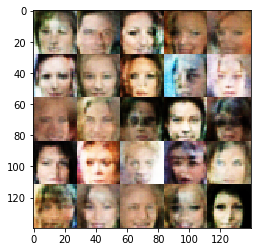

Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.1845
Epoch 1/1... Discriminator Loss: 0.0848... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: -0.4378... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.1411
Epoch 1/1... Discriminator Loss: 0.1428... Generator Loss: 0.4483
Epoch 1/1... Discriminator Loss: -0.8182... Generator Loss: 1.5252
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 0.2663
Epoch 1/1... Discriminator Loss: 0.5786... Generator Loss: 0.3436
Epoch 1/1... Discriminator Loss: 0.0944... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 0.3645... Generator Loss: 0.4388


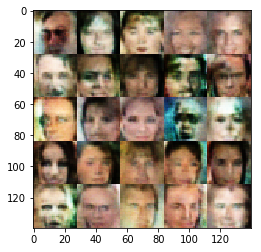

Epoch 1/1... Discriminator Loss: 0.6532... Generator Loss: 0.2998
Epoch 1/1... Discriminator Loss: -0.3281... Generator Loss: 3.7479
Epoch 1/1... Discriminator Loss: -0.4243... Generator Loss: 1.3047
Epoch 1/1... Discriminator Loss: -0.0577... Generator Loss: 2.6293
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.0925
Epoch 1/1... Discriminator Loss: 0.4238... Generator Loss: 0.3550
Epoch 1/1... Discriminator Loss: 0.1607... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 0.1831... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: -0.4170... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 2.5238... Generator Loss: 0.0394


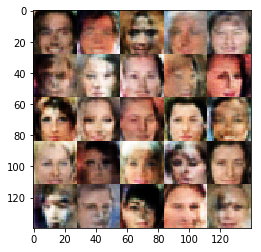

Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 0.3623
Epoch 1/1... Discriminator Loss: 0.1726... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: -0.4409... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 0.1094... Generator Loss: 0.3177
Epoch 1/1... Discriminator Loss: 0.2272... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.0976
Epoch 1/1... Discriminator Loss: 0.0906... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.1320
Epoch 1/1... Discriminator Loss: -0.3473... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: -0.5306... Generator Loss: 4.3151


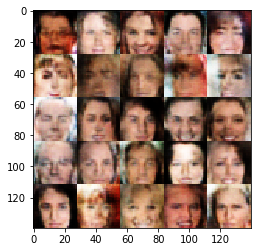

Epoch 1/1... Discriminator Loss: 0.1360... Generator Loss: 2.6135
Epoch 1/1... Discriminator Loss: -0.0745... Generator Loss: 3.8047
Epoch 1/1... Discriminator Loss: 0.1547... Generator Loss: 1.3216
Epoch 1/1... Discriminator Loss: 0.1106... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: -0.0248... Generator Loss: 1.5774
Epoch 1/1... Discriminator Loss: 0.3067... Generator Loss: 2.2000
Epoch 1/1... Discriminator Loss: 0.0960... Generator Loss: 0.3763
Epoch 1/1... Discriminator Loss: 0.4980... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.1495
Epoch 1/1... Discriminator Loss: 2.3355... Generator Loss: 0.0329


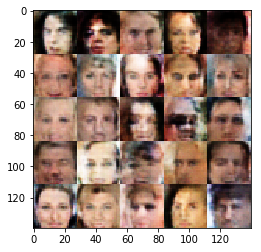

Epoch 1/1... Discriminator Loss: -0.3880... Generator Loss: 2.5844
Epoch 1/1... Discriminator Loss: 0.5254... Generator Loss: 0.4427
Epoch 1/1... Discriminator Loss: -0.3772... Generator Loss: 1.9641
Epoch 1/1... Discriminator Loss: -0.2001... Generator Loss: 3.7818
Epoch 1/1... Discriminator Loss: 0.2015... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 3.0176... Generator Loss: 0.0332
Epoch 1/1... Discriminator Loss: -0.1801... Generator Loss: 1.2005
Epoch 1/1... Discriminator Loss: -0.9799... Generator Loss: 1.2183
Epoch 1/1... Discriminator Loss: 1.7791... Generator Loss: 0.1015
Epoch 1/1... Discriminator Loss: 2.1316... Generator Loss: 0.0548


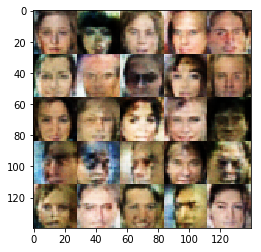

Epoch 1/1... Discriminator Loss: -0.2294... Generator Loss: 2.0034
Epoch 1/1... Discriminator Loss: 0.0662... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.9934... Generator Loss: 0.2646
Epoch 1/1... Discriminator Loss: 0.2639... Generator Loss: 2.7180
Epoch 1/1... Discriminator Loss: -0.1800... Generator Loss: 2.8131
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.2908
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.2629
Epoch 1/1... Discriminator Loss: 2.2561... Generator Loss: 0.0789
Epoch 1/1... Discriminator Loss: 0.4748... Generator Loss: 0.3501
Epoch 1/1... Discriminator Loss: 0.2885... Generator Loss: 3.5385


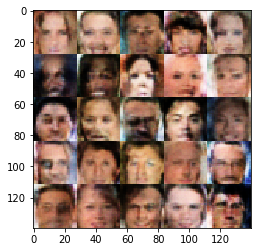

Epoch 1/1... Discriminator Loss: 0.0564... Generator Loss: 2.1693
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.2028
Epoch 1/1... Discriminator Loss: 0.3694... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.9638... Generator Loss: 0.1476
Epoch 1/1... Discriminator Loss: -0.0577... Generator Loss: 2.5333
Epoch 1/1... Discriminator Loss: 0.1493... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 0.0791... Generator Loss: 4.1314
Epoch 1/1... Discriminator Loss: 0.0163... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 0.3437
Epoch 1/1... Discriminator Loss: -0.2643... Generator Loss: 2.4969


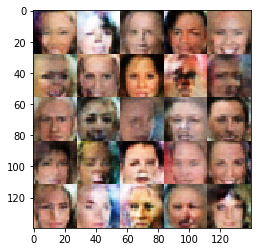

Epoch 1/1... Discriminator Loss: 1.8210... Generator Loss: 0.1030
Epoch 1/1... Discriminator Loss: -0.3027... Generator Loss: 1.9029
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.2178
Epoch 1/1... Discriminator Loss: 0.6895... Generator Loss: 0.3117
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.1794
Epoch 1/1... Discriminator Loss: -0.4273... Generator Loss: 4.7973
Epoch 1/1... Discriminator Loss: -0.0624... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: -0.3148... Generator Loss: 3.3950
Epoch 1/1... Discriminator Loss: -0.0701... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 2.0354... Generator Loss: 0.0610


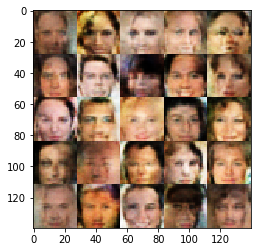

Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.2456
Epoch 1/1... Discriminator Loss: -0.3715... Generator Loss: 2.9095
Epoch 1/1... Discriminator Loss: -0.5999... Generator Loss: 4.0195
Epoch 1/1... Discriminator Loss: 0.2428... Generator Loss: 0.4077
Epoch 1/1... Discriminator Loss: 0.2141... Generator Loss: 1.0896
Epoch 1/1... Discriminator Loss: 0.4487... Generator Loss: 0.3730
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.2842
Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 0.2749
Epoch 1/1... Discriminator Loss: -0.3158... Generator Loss: 2.2483
Epoch 1/1... Discriminator Loss: -0.0082... Generator Loss: 3.0733


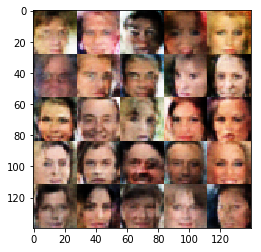

Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.1293
Epoch 1/1... Discriminator Loss: 1.8917... Generator Loss: 0.1335
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 0.3740
Epoch 1/1... Discriminator Loss: -0.0907... Generator Loss: 0.5051
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.1552
Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 0.3347
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.2184
Epoch 1/1... Discriminator Loss: -0.2685... Generator Loss: 3.3655
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 0.3494
Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 0.4573


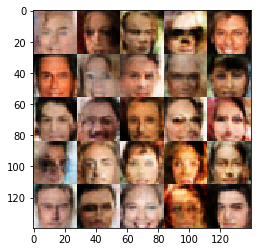

Epoch 1/1... Discriminator Loss: 0.2193... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 0.2524... Generator Loss: 1.5205
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.2440
Epoch 1/1... Discriminator Loss: 1.9753... Generator Loss: 0.1111
Epoch 1/1... Discriminator Loss: 2.6813... Generator Loss: 0.0246
Epoch 1/1... Discriminator Loss: -0.1259... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 0.5606... Generator Loss: 0.4064
Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 1.3969
Epoch 1/1... Discriminator Loss: 0.4320... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: -1.0600... Generator Loss: 2.1077


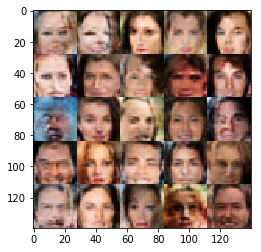

Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: -0.4492... Generator Loss: 1.2151
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.2263
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 0.3925
Epoch 1/1... Discriminator Loss: -0.2696... Generator Loss: 1.5324
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.1339
Epoch 1/1... Discriminator Loss: 0.1559... Generator Loss: 1.6209
Epoch 1/1... Discriminator Loss: -0.2326... Generator Loss: 0.2596
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 0.2857
Epoch 1/1... Discriminator Loss: -0.3729... Generator Loss: 5.1446


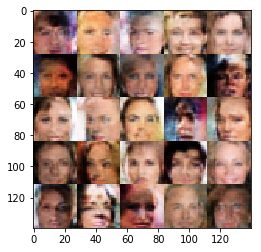

Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 0.3179
Epoch 1/1... Discriminator Loss: 0.1439... Generator Loss: 0.4008
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.2068
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.1148
Epoch 1/1... Discriminator Loss: 1.9301... Generator Loss: 0.1175
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: -0.2604... Generator Loss: 3.4593
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.2995
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.1218
Epoch 1/1... Discriminator Loss: 0.4219... Generator Loss: 0.3889


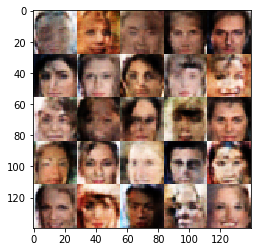

Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 0.2312
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.1529
Epoch 1/1... Discriminator Loss: -0.6114... Generator Loss: 1.3702
Epoch 1/1... Discriminator Loss: 1.7265... Generator Loss: 0.1005
Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.1136
Epoch 1/1... Discriminator Loss: 0.1255... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 1.6151... Generator Loss: 0.0783
Epoch 1/1... Discriminator Loss: 2.0790... Generator Loss: 0.0998
Epoch 1/1... Discriminator Loss: 0.1892... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 0.1731... Generator Loss: 3.2582


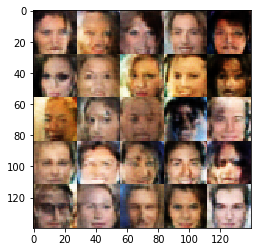

Epoch 1/1... Discriminator Loss: 0.4614... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 0.3338
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 0.2711
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.1754
Epoch 1/1... Discriminator Loss: 1.9940... Generator Loss: 0.0715
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.1721
Epoch 1/1... Discriminator Loss: -0.1743... Generator Loss: 1.3387
Epoch 1/1... Discriminator Loss: -0.0317... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 1.9209... Generator Loss: 4.2225
Epoch 1/1... Discriminator Loss: -0.2326... Generator Loss: 2.1273


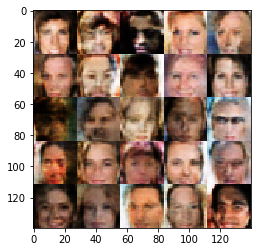

Epoch 1/1... Discriminator Loss: 0.2921... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.5573... Generator Loss: 0.1420
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.1522
Epoch 1/1... Discriminator Loss: -0.0801... Generator Loss: 1.6132
Epoch 1/1... Discriminator Loss: -0.0871... Generator Loss: 1.9725
Epoch 1/1... Discriminator Loss: -0.6914... Generator Loss: 5.3690
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.2219
Epoch 1/1... Discriminator Loss: -0.6150... Generator Loss: 2.8110
Epoch 1/1... Discriminator Loss: -0.1953... Generator Loss: 2.7020
Epoch 1/1... Discriminator Loss: -0.5142... Generator Loss: 1.5747


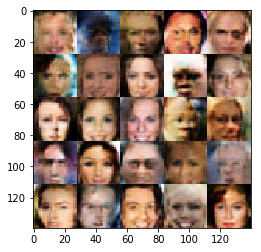

Epoch 1/1... Discriminator Loss: 1.6771... Generator Loss: 0.2127
Epoch 1/1... Discriminator Loss: -0.1666... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: -0.5699... Generator Loss: 1.8800
Epoch 1/1... Discriminator Loss: 0.2470... Generator Loss: 0.4534
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.2141
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.1261
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 0.1698
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.1378
Epoch 1/1... Discriminator Loss: 4.1633... Generator Loss: 5.8579
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 0.2762


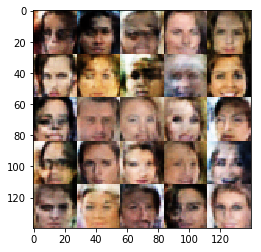

Epoch 1/1... Discriminator Loss: 0.7736... Generator Loss: 0.3937
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 0.4154
Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 0.3493
Epoch 1/1... Discriminator Loss: 0.3420... Generator Loss: 0.4747
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.2577
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: -0.5827... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 2.0182... Generator Loss: 0.0710
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 0.1645
Epoch 1/1... Discriminator Loss: 0.6965... Generator Loss: 0.4971


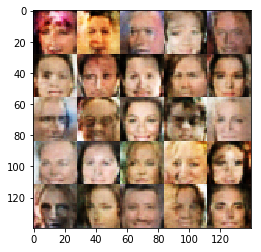

Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 0.2728
Epoch 1/1... Discriminator Loss: 1.8196... Generator Loss: 0.0850
Epoch 1/1... Discriminator Loss: -0.5596... Generator Loss: 1.3319
Epoch 1/1... Discriminator Loss: -1.0415... Generator Loss: 1.5531
Epoch 1/1... Discriminator Loss: 1.6064... Generator Loss: 0.1363
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.1415
Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.8219... Generator Loss: 0.0715
Epoch 1/1... Discriminator Loss: -0.3144... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.2099


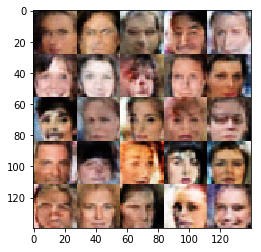

Epoch 1/1... Discriminator Loss: 1.8528... Generator Loss: 0.0553
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 0.2832
Epoch 1/1... Discriminator Loss: 0.0879... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: -0.0641... Generator Loss: 1.2670
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 0.2370
Epoch 1/1... Discriminator Loss: 0.0516... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 0.3559
Epoch 1/1... Discriminator Loss: 1.7815... Generator Loss: 0.1222
Epoch 1/1... Discriminator Loss: 0.1793... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.9257... Generator Loss: 0.0973


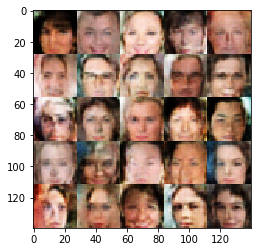

Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.1931
Epoch 1/1... Discriminator Loss: 0.5547... Generator Loss: 0.2457
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 0.2510
Epoch 1/1... Discriminator Loss: 0.2329... Generator Loss: 0.4369
Epoch 1/1... Discriminator Loss: -1.1809... Generator Loss: 1.5638
Epoch 1/1... Discriminator Loss: 2.0398... Generator Loss: 0.0626
Epoch 1/1... Discriminator Loss: 3.4479... Generator Loss: 0.0356
Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.1448
Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 0.4551


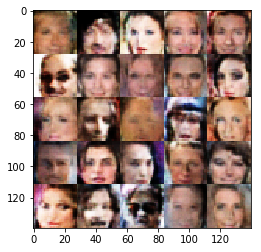

Epoch 1/1... Discriminator Loss: -1.9394... Generator Loss: 2.2296
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 0.1756
Epoch 1/1... Discriminator Loss: 2.8099... Generator Loss: 0.0377
Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 0.3322
Epoch 1/1... Discriminator Loss: 2.8922... Generator Loss: 0.0474
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 0.2346
Epoch 1/1... Discriminator Loss: -0.0950... Generator Loss: 1.6148
Epoch 1/1... Discriminator Loss: 0.3030... Generator Loss: 3.2036
Epoch 1/1... Discriminator Loss: -0.4953... Generator Loss: 3.1852
Epoch 1/1... Discriminator Loss: 0.1687... Generator Loss: 0.3749


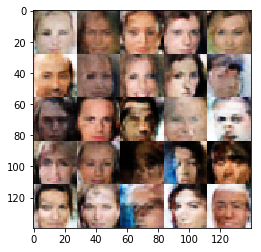

Epoch 1/1... Discriminator Loss: -0.3261... Generator Loss: 1.8051
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.1015
Epoch 1/1... Discriminator Loss: -0.1560... Generator Loss: 3.9441
Epoch 1/1... Discriminator Loss: 1.5931... Generator Loss: 0.1259
Epoch 1/1... Discriminator Loss: 0.5760... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.2055
Epoch 1/1... Discriminator Loss: 2.1189... Generator Loss: 0.0663
Epoch 1/1... Discriminator Loss: 0.4925... Generator Loss: 0.2486
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 0.2351
Epoch 1/1... Discriminator Loss: -0.1575... Generator Loss: 1.7178


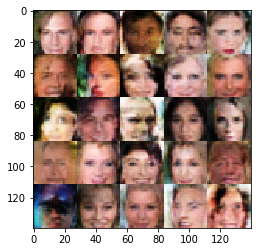

Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 0.2096
Epoch 1/1... Discriminator Loss: 1.9883... Generator Loss: 0.0660
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 0.2062
Epoch 1/1... Discriminator Loss: -0.5295... Generator Loss: 4.7692
Epoch 1/1... Discriminator Loss: 0.5403... Generator Loss: 0.3184
Epoch 1/1... Discriminator Loss: 1.6897... Generator Loss: 0.1255
Epoch 1/1... Discriminator Loss: -0.0828... Generator Loss: 1.5643
Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 4.9527
Epoch 1/1... Discriminator Loss: -0.0379... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.2172


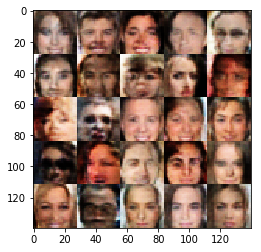

Epoch 1/1... Discriminator Loss: -0.4956... Generator Loss: 2.0661
Epoch 1/1... Discriminator Loss: 0.0367... Generator Loss: 0.4877
Epoch 1/1... Discriminator Loss: -0.2070... Generator Loss: 1.9568
Epoch 1/1... Discriminator Loss: 1.7518... Generator Loss: 0.1268
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 0.3353
Epoch 1/1... Discriminator Loss: 2.2309... Generator Loss: 3.0499
Epoch 1/1... Discriminator Loss: -0.4199... Generator Loss: 1.8711
Epoch 1/1... Discriminator Loss: -0.4814... Generator Loss: 1.4896
Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 0.3180
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.2028


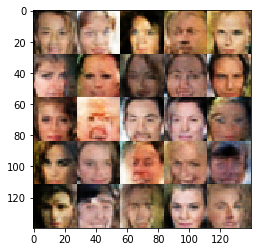

Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.1789
Epoch 1/1... Discriminator Loss: 2.6745... Generator Loss: 0.0552
Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 0.2504
Epoch 1/1... Discriminator Loss: 1.7295... Generator Loss: 0.1018
Epoch 1/1... Discriminator Loss: -0.0267... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 0.5441... Generator Loss: 0.2495
Epoch 1/1... Discriminator Loss: -0.0070... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 2.5761... Generator Loss: 8.6553
Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 0.2780
Epoch 1/1... Discriminator Loss: 0.0781... Generator Loss: 1.9736


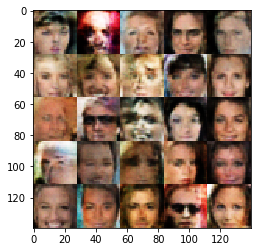

Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.1831
Epoch 1/1... Discriminator Loss: 2.1269... Generator Loss: 0.0708
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 0.3162
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.2232
Epoch 1/1... Discriminator Loss: 2.0392... Generator Loss: 0.0351
Epoch 1/1... Discriminator Loss: 0.0662... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.1755
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.1097
Epoch 1/1... Discriminator Loss: 3.4613... Generator Loss: 0.0380


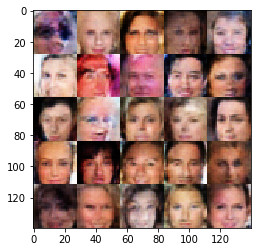

Epoch 1/1... Discriminator Loss: 2.5827... Generator Loss: 0.0681
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 0.2106
Epoch 1/1... Discriminator Loss: -0.5873... Generator Loss: 6.0357
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 0.2293
Epoch 1/1... Discriminator Loss: 0.5968... Generator Loss: 4.6971
Epoch 1/1... Discriminator Loss: 0.6772... Generator Loss: 4.3351
Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: -0.2154... Generator Loss: 0.2875
Epoch 1/1... Discriminator Loss: 0.4783... Generator Loss: 0.4287
Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 0.2554


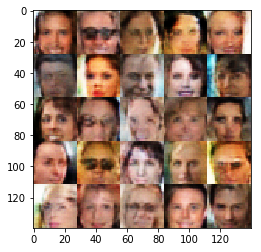

Epoch 1/1... Discriminator Loss: -0.6267... Generator Loss: 3.1921
Epoch 1/1... Discriminator Loss: -0.2056... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: -0.7144... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 0.6941... Generator Loss: 0.3201
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 0.1644
Epoch 1/1... Discriminator Loss: -1.1165... Generator Loss: 1.7386
Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.0531
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 0.1667
Epoch 1/1... Discriminator Loss: -0.5286... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 2.3083... Generator Loss: 0.0332


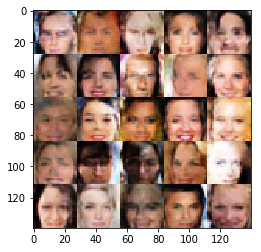

Epoch 1/1... Discriminator Loss: 0.1718... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 3.1083... Generator Loss: 0.0218
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.1595
Epoch 1/1... Discriminator Loss: 0.6581... Generator Loss: 0.2305
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.2538
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 0.2112
Epoch 1/1... Discriminator Loss: 0.0687... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 0.1635
Epoch 1/1... Discriminator Loss: 2.1427... Generator Loss: 0.1570
Epoch 1/1... Discriminator Loss: 0.5408... Generator Loss: 0.4633


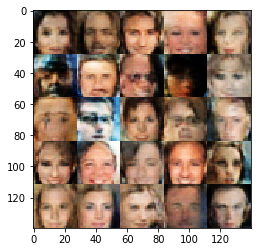

Epoch 1/1... Discriminator Loss: 0.7842... Generator Loss: 0.3602
Epoch 1/1... Discriminator Loss: 0.4783... Generator Loss: 0.4376
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.2756
Epoch 1/1... Discriminator Loss: 1.7142... Generator Loss: 0.0544
Epoch 1/1... Discriminator Loss: 0.4347... Generator Loss: 0.4143
Epoch 1/1... Discriminator Loss: 0.3063... Generator Loss: 0.3244
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.2778
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.1647
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 0.2856
Epoch 1/1... Discriminator Loss: 0.0833... Generator Loss: 0.8735


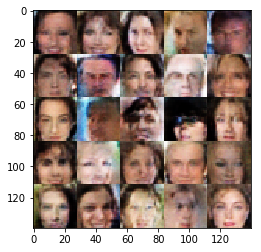

Epoch 1/1... Discriminator Loss: -0.3993... Generator Loss: 4.5920
Epoch 1/1... Discriminator Loss: 0.1926... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: -0.5761... Generator Loss: 1.4226
Epoch 1/1... Discriminator Loss: -0.0552... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.9289... Generator Loss: 0.0962
Epoch 1/1... Discriminator Loss: 0.1061... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.1705
Epoch 1/1... Discriminator Loss: -0.6528... Generator Loss: 1.9234
Epoch 1/1... Discriminator Loss: -0.5550... Generator Loss: 2.4002
Epoch 1/1... Discriminator Loss: 0.3063... Generator Loss: 0.3259


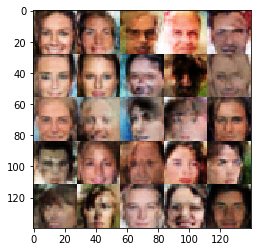

Epoch 1/1... Discriminator Loss: 0.4452... Generator Loss: 5.3173
Epoch 1/1... Discriminator Loss: -0.2875... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.6624... Generator Loss: 0.1412
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 5.2365
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.2167
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.1985
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 0.3804
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 0.3471
Epoch 1/1... Discriminator Loss: 2.2895... Generator Loss: 0.0844
Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 3.5077


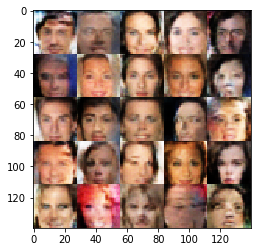

Epoch 1/1... Discriminator Loss: 0.2201... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.1715
Epoch 1/1... Discriminator Loss: 4.1213... Generator Loss: 0.0079
Epoch 1/1... Discriminator Loss: 0.2010... Generator Loss: 0.4103
Epoch 1/1... Discriminator Loss: 0.7940... Generator Loss: 0.3269
Epoch 1/1... Discriminator Loss: 1.7931... Generator Loss: 0.0784
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 0.2643
Epoch 1/1... Discriminator Loss: 0.2911... Generator Loss: 0.3399
Epoch 1/1... Discriminator Loss: 1.8201... Generator Loss: 0.0554
Epoch 1/1... Discriminator Loss: -0.0677... Generator Loss: 1.1823


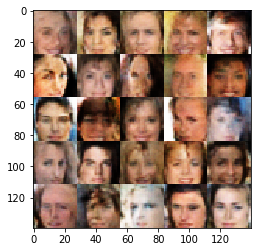

Epoch 1/1... Discriminator Loss: 1.7903... Generator Loss: 0.1314
Epoch 1/1... Discriminator Loss: 1.8314... Generator Loss: 0.0762
Epoch 1/1... Discriminator Loss: -0.6635... Generator Loss: 3.5521
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 0.2377
Epoch 1/1... Discriminator Loss: 2.5120... Generator Loss: 0.0379
Epoch 1/1... Discriminator Loss: 0.1912... Generator Loss: 0.3188
Epoch 1/1... Discriminator Loss: 0.4832... Generator Loss: 0.3997
Epoch 1/1... Discriminator Loss: 1.9531... Generator Loss: 0.1329
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 5.0621
Epoch 1/1... Discriminator Loss: -1.4089... Generator Loss: 2.9920


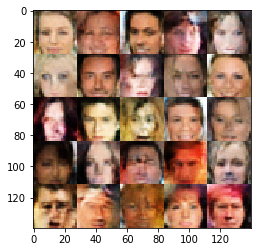

Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.1553
Epoch 1/1... Discriminator Loss: 0.2571... Generator Loss: 0.5176
Epoch 1/1... Discriminator Loss: 0.1631... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 6.5297
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 0.2966... Generator Loss: 4.8750
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 0.2752
Epoch 1/1... Discriminator Loss: -0.2902... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 2.1770... Generator Loss: 0.0691
Epoch 1/1... Discriminator Loss: -0.1786... Generator Loss: 2.6771


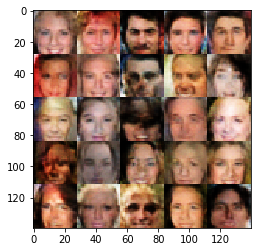

Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: -0.0301... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 4.7794
Epoch 1/1... Discriminator Loss: -0.5235... Generator Loss: 1.9843
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.3787
Epoch 1/1... Discriminator Loss: 0.6987... Generator Loss: 0.2919
Epoch 1/1... Discriminator Loss: -0.5275... Generator Loss: 1.5124
Epoch 1/1... Discriminator Loss: 0.2460... Generator Loss: 0.4328
Epoch 1/1... Discriminator Loss: -1.0946... Generator Loss: 1.3849
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 0.5844


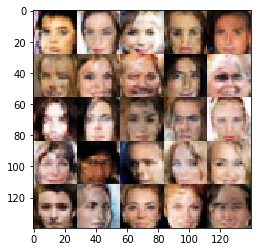

Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 0.0819
Epoch 1/1... Discriminator Loss: -0.1092... Generator Loss: 1.9586
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 0.2179
Epoch 1/1... Discriminator Loss: -1.4778... Generator Loss: 2.4109
Epoch 1/1... Discriminator Loss: 2.3983... Generator Loss: 0.0430
Epoch 1/1... Discriminator Loss: 0.5393... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 3.0103... Generator Loss: 7.3184
Epoch 1/1... Discriminator Loss: -1.2753... Generator Loss: 1.6621
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.0730
Epoch 1/1... Discriminator Loss: 0.5764... Generator Loss: 0.3485


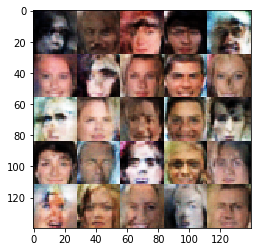

Epoch 1/1... Discriminator Loss: -0.2417... Generator Loss: 1.4512
Epoch 1/1... Discriminator Loss: -0.5999... Generator Loss: 1.6807
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 0.2936


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.